## Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_auc_score, confusion_matrix

warnings.simplefilter(action='ignore', category=FutureWarning)

## Código

### Carga de archivos

In [2]:
clients_cdp = pd.read_csv("data/cliente_planes - cliente_cdp.csv")
print(f"Shape of the dataframe: {clients_cdp.shape}.")

Shape of the dataframe: (32618, 3).


In [3]:
all_clients = pd.read_csv("data/datos_clientes - dataset.csv")
print(f"Shape of the dataframe: {all_clients.shape}.")

Shape of the dataframe: (10901, 7).


In [4]:
call_billing = pd.read_csv("data/facturacion_duracion_llamadas_trimestre - f.csv")
print(f"Shape of the dataframe: {call_billing.shape}.")

Shape of the dataframe: (10900, 3).


In [5]:
segments = pd.read_csv("data/segmentos.csv")
print(f"Shape of the dataframe: {segments.shape}.")

Shape of the dataframe: (1389, 4).


### Unión y exploración de la data

In [6]:
clients_cdp["nro_cliente"].duplicated().sum()

np.int64(21718)

In [7]:
all_clients["nro_cliente"].duplicated().sum()

np.int64(0)

In [8]:
df = pd.merge(left=clients_cdp, right=all_clients, on="nro_cliente", how="left")
df.head()

,mes,nro_cliente,Plan_mes,user_id,install_time,platform,country_region,city,gender
0,1,1,95729,10045a3c,2018-07-03 0:02:10,Android,Santa Fe,Avellaneda,male
1,1,3,96410,1004d93d,2018-07-06 23:09:52,Android,Buenos Aires,San Isidro,female
2,1,2,96400,1006ac06,2018-07-05 23:03:47,Android,Cordoba,Córdoba,male
3,1,5,95729,100bc465,2018-07-07 17:02:46,Android,Formosa,Formosa,female
4,1,4,95420,100bcd07,2018-06-30 3:21:43,Android,Buenos Aires,Lanus,male


In [9]:
call_billing["nro_cliente"].duplicated().sum()

np.int64(0)

In [10]:
df = df.merge(right=call_billing, on="nro_cliente", how="left")
df.head()

,mes,nro_cliente,Plan_mes,user_id,install_time,platform,country_region,city,gender,sum_fact,sum_duracion
0,1,1,95729,10045a3c,2018-07-03 0:02:10,Android,Santa Fe,Avellaneda,male,645.007199,330.775190
1,1,3,96410,1004d93d,2018-07-06 23:09:52,Android,Buenos Aires,San Isidro,female,520.514551,565.763348
2,1,2,96400,1006ac06,2018-07-05 23:03:47,Android,Cordoba,Córdoba,male,1330.167700,30.000000
3,1,5,95729,100bc465,2018-07-07 17:02:46,Android,Formosa,Formosa,female,555.171059,99.929049
4,1,4,95420,100bcd07,2018-06-30 3:21:43,Android,Buenos Aires,Lanus,male,1534.166310,371.433155


In [11]:
segments["user_id"].duplicated().sum()

np.int64(5)

In [12]:
dups_users_segments = segments.loc[segments["user_id"].duplicated(), "user_id"].unique().tolist()

In [13]:
segments[segments["user_id"].isin(dups_users_segments)]

,user_id,target_churn_indicator,range_group,n_previous_registers
539,6f1e1709,0,b,1
540,6f1e1709,0,b,2
587,75d198ce,0,b,1
588,75d198ce,0,b,2
589,75d198ce,0,b,3
679,85ef5dfe,0,a,1
680,85ef5dfe,0,a,2
1003,c103db74,1,b,1
1004,c103db74,1,b,2


Ya que *n_previous_registers* hace referencia a la *cantidad de veces que un cliente estuvo en campaña de upgrade*, se procede a eliminar los duplicados por *user_id* de menor cantidad de registros previos (esta variable es acumulativa).

In [14]:
segments = segments.sort_values(by=["user_id", "n_previous_registers"], ascending=[True, False])

In [15]:
segments[segments["user_id"]=="75d198ce"]

,user_id,target_churn_indicator,range_group,n_previous_registers
589,75d198ce,0,b,3
588,75d198ce,0,b,2
587,75d198ce,0,b,1


In [16]:
segments = segments.drop_duplicates(subset=["user_id"], keep="first")

In [17]:
segments[segments["user_id"]=="75d198ce"]

,user_id,target_churn_indicator,range_group,n_previous_registers
589,75d198ce,0,b,3


In [18]:
segments["user_id"].duplicated().sum()

np.int64(0)

In [19]:
df = df.merge(right=segments, on="user_id", how="left")
df.head()

,mes,nro_cliente,Plan_mes,user_id,install_time,platform,country_region,city,gender,sum_fact,sum_duracion,target_churn_indicator,range_group,n_previous_registers
0,1,1,95729,10045a3c,2018-07-03 0:02:10,Android,Santa Fe,Avellaneda,male,645.007199,330.775190,NaN,NaN,NaN
1,1,3,96410,1004d93d,2018-07-06 23:09:52,Android,Buenos Aires,San Isidro,female,520.514551,565.763348,NaN,NaN,NaN
2,1,2,96400,1006ac06,2018-07-05 23:03:47,Android,Cordoba,Córdoba,male,1330.167700,30.000000,0.0,b,1.0
3,1,5,95729,100bc465,2018-07-07 17:02:46,Android,Formosa,Formosa,female,555.171059,99.929049,NaN,NaN,NaN
4,1,4,95420,100bcd07,2018-06-30 3:21:43,Android,Buenos Aires,Lanus,male,1534.166310,371.433155,NaN,NaN,NaN


In [20]:
# Se verifica que la cantidad de filas del dataframe df sea igual a la cantidad de clientes en clients_cdp
df.shape[0] == clients_cdp.shape[0]

True

In [21]:
df.isna().sum()

mes                           0
nro_cliente                   0
Plan_mes                      0
user_id                       0
install_time                  0
platform                      0
country_region                0
city                          0
gender                        0
sum_fact                      0
sum_duracion                  0
target_churn_indicator    30100
range_group               30100
n_previous_registers      30100
dtype: int64

Se asume a continuación que si el cliente no está en la tabla de segmentos es porque NUNCA ha hecho parte de las campañas.

En este sentido, se asume que *target_churn_indicator = 0* y *n_previous_registers = 0*; *range_group* no se puede identificar.

In [22]:
df.fillna({"target_churn_indicator": 0}, inplace=True)
df.fillna({"n_previous_registers": 0}, inplace=True)

In [23]:
# Resumen genérico del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32618 entries, 0 to 32617
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mes                     32618 non-null  int64  
 1   nro_cliente             32618 non-null  int64  
 2   Plan_mes                32618 non-null  int64  
 3   user_id                 32618 non-null  object 
 4   install_time            32618 non-null  object 
 5   platform                32618 non-null  object 
 6   country_region          32618 non-null  object 
 7   city                    32618 non-null  object 
 8   gender                  32618 non-null  object 
 9   sum_fact                32618 non-null  float64
 10  sum_duracion            32618 non-null  float64
 11  target_churn_indicator  32618 non-null  float64
 12  range_group             2518 non-null   object 
 13  n_previous_registers    32618 non-null  float64
dtypes: float64(4), int64(3), object(7)
mem

In [24]:
df.dtypes

mes                         int64
nro_cliente                 int64
Plan_mes                    int64
user_id                    object
install_time               object
platform                   object
country_region             object
city                       object
gender                     object
sum_fact                  float64
sum_duracion              float64
target_churn_indicator    float64
range_group                object
n_previous_registers      float64
dtype: object

In [25]:
# Se cambian los tipos de datos de algunas variables
df["install_time"] = pd.to_datetime(df["install_time"])
df["nro_cliente"] = df["nro_cliente"].astype("category")
df["mes"] = df["mes"].astype("category")
df["Plan_mes"] = df["Plan_mes"].astype("category")
df["target_churn_indicator"] = df["target_churn_indicator"].astype('int64')
df["n_previous_registers"] = df["n_previous_registers"].astype('int64')

In [26]:
# Las variables con tipo de datos object se convierten a categóricas
df = df.astype({col: 'category' for col in df.select_dtypes(include='object').columns})

### Pregunta 1: ¿cuántos clientes tuvieron al menos un cambio de plan?

In [27]:
# Se agrupa la información según la pregunta
number_plans_per_client = df.groupby(["nro_cliente"], as_index=False)["Plan_mes"].nunique()
number_plans_per_client = number_plans_per_client.rename(columns={"Plan_mes": "num_planes"})

In [28]:
# Muestra de clientes específicos que tienen más de un plan
number_plans_per_client[number_plans_per_client["num_planes"]>1]

,nro_cliente,num_planes
0,1,2
3,4,2
4,5,2
5,6,2
7,8,2
...,...,...
10859,10860,2
10860,10861,2
10863,10864,2
10894,10895,2


In [29]:
# Número total de clientes únicos que tienen más de un plan
number_plans_per_client[number_plans_per_client["num_planes"]>1].shape[0]

5847

In [30]:
# Ejemplo 1 de cliente que cambió de plan al menos una vez en el trimestre
df.loc[df["nro_cliente"]==10861, ["nro_cliente", "Plan_mes"]]

,nro_cliente,Plan_mes
13277,10861,96420
32578,10861,96916


In [31]:
# Ejemplo 2 de cliente que cambió de plan al menos una vez en el trimestre
df.loc[df["nro_cliente"]==8, ["nro_cliente", "Plan_mes"]]

,nro_cliente,Plan_mes
6,8,94497
13263,8,97120
21725,8,97120


#### **Conclusión**

Del total de clientes, hay 5847 que cambiaron de plan durante el trimestre.

### Pregunta 2: ¿existe alguna relación entre country_region y los cambios de planes en el trimestre?

In [32]:
# En un nuevo dataframe extraigo únicamente las columnas que necesito
clients_vs_regions = df.loc[:, ["nro_cliente", "country_region"]].drop_duplicates().reset_index(drop=True)

In [33]:
# Unión de este nuevo dataframe con el de la pregunta 1 (number_plans_per_client)
df_q2 = pd.merge(left=clients_vs_regions, right=number_plans_per_client, on="nro_cliente", how="inner")

In [34]:
# Se crea una variable que indique si el cliente cambió de plan (el número de planes no es relevante para esta pregunta)
df_q2["cambio_plan"] = df_q2["num_planes"].apply(lambda x: 1 if x > 1 else 0)

In [35]:
# Muestra general de todas las regiones disponibles -> Es necesario recategorizar para encontrar alguna conclusión general
df_q2["country_region"].value_counts(dropna=False)

country_region
Buenos Aires           3658
Buenos Aires F.D.      1690
Cordoba                1114
Entre Rios              675
Santa Fe                507
Tucuman                 422
Salta                   399
Mendoza                 384
Chaco                   211
Misiones                209
Corrientes              184
Neuquen                 155
San Luis                148
Formosa                 133
La Rioja                131
Chubut                  122
San Juan                117
Santiago del Estero     114
Jujuy                   113
Rio Negro               105
La Pampa                 94
Catamarca                86
Santa Cruz               66
Tierra del Fuego         47
Entre Ríos Province       8
Santa Fe Province         2
Cordoba Province          2
Chaco Province            1
Neuquén Province          1
Río Negro Province        1
Tucumán Province          1
Name: count, dtype: int64

In [36]:
# Se evidencia que más del 80% de los clientes se ubican en 8 regiones (Pareto)
df_q2["country_region"].value_counts(normalize=True)[0:8].sum()

np.float64(0.8118348623853211)

In [37]:
# Se almacenan las regiones más usuales en una lista
list_main_regions = df_q2["country_region"].value_counts(normalize=True)[0:8].index.tolist()

In [38]:
# Muestra de tales regiones
list_main_regions

['Buenos Aires',
 'Buenos Aires F.D.',
 'Cordoba',
 'Entre Rios',
 'Santa Fe',
 'Tucuman',
 'Salta',
 'Mendoza']

In [39]:
# Recategorización de la región asociada a los clientes
df_q2["country_region_recat"] = df_q2["country_region"].apply(lambda x: x if x in list_main_regions else "Otra")

In [40]:
# Tabla cruzada entre la región recategorizada y el cambio de plan (0: no cambió de plan; 1: cambió de plan), con proporciones por filas
crosstab_q2 = pd.crosstab(df_q2["country_region_recat"], df_q2["cambio_plan"], normalize="index")
crosstab_q2 = crosstab_q2.sort_values(by=[1], ascending=False)
crosstab_q2

cambio_plan,0,1
country_region_recat,,
Mendoza,0.406250,0.593750
Buenos Aires F.D.,0.454438,0.545562
Otra,0.457825,0.542175
Salta,0.461153,0.538847
Buenos Aires,0.465555,0.534445
Santa Fe,0.469428,0.530572
Cordoba,0.477558,0.522442
Entre Rios,0.481481,0.518519
Tucuman,0.492891,0.507109


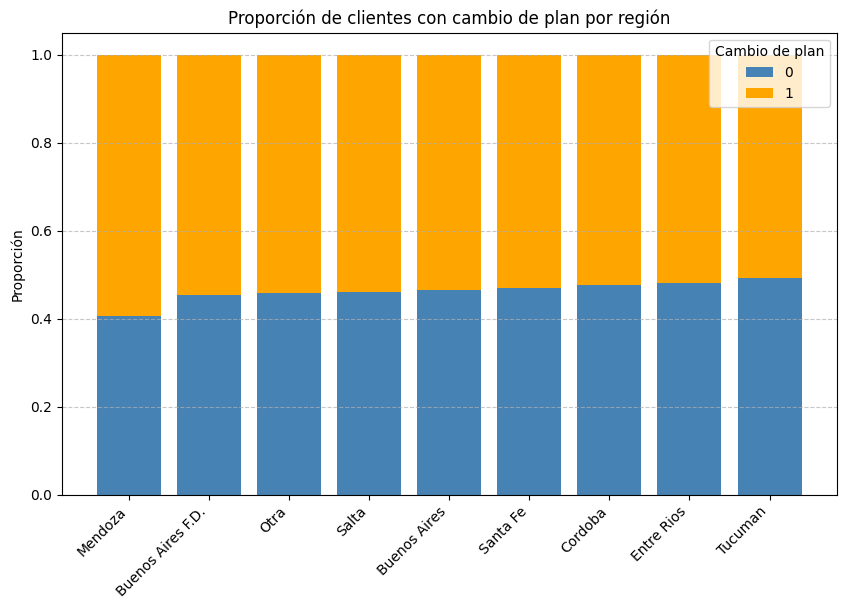

In [41]:
# Plot con barras apiladas para comparar visualmente los resultados de la tabla cruzada anterior
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(crosstab_q2.index, crosstab_q2[0], label=0, color="steelblue")
ax.bar(crosstab_q2.index, crosstab_q2[1], bottom=crosstab_q2[0], label=1, color="orange")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Proporción")
plt.title("Proporción de clientes con cambio de plan por región")
plt.legend(title="Cambio de plan")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [42]:
# Proporción media de clientes que han cambiado de plan, sin discriminar por región
df_q2["cambio_plan"].mean()

np.float64(0.5364220183486239)

#### **Conclusión**

A nivel descriptivo y considerando las principales regiones de Argentina, es posible decir que Mendoza presenta la mayor proporción de clientes con cambio de plan (0.59) que, sin embargo, no parece diferir en gran medida de la proporción media de clientes en todas las regiones que lo hicieron (0.54). El resto de las regiones principales se mantienen más o menos constantes en cuanto a dicha proporción, oscilando en un mínimo de 0.51 para Tucuman y un máximo de 0.55 para Buenos Aires F.D.

Por lo tanto, contestando a la pregunta inicial, a nivel descriptivo no parece existir una relación entre la variable *country_region* y los cambios de planes en el trimestre, exceptuando tal vez el caso puntual de la región de Mendoza.

Más adelante se revisará si esta región específica (y también el resto de regiones), tienen alguna relación significativa con los clientes que cambiaron de plan.

### Pregunta 3: ¿cuáles serían las tres principales características de los clientes que realizan cambios de plan?

#### Usando estadísticas y gráficos descriptivos

In [43]:
# Se crea un nuevo dataframe para esta pregunta específica eliminando variables que hacen ruido
# Se elimina el mes porque se revisará en general a los clientes, no desagregados según el periodo
# Se eliminar el rango de edad (range_group) por la alta cantidad de valores faltantes sin posibilidad de imputar adecuadamente
df_q3 = df.drop(columns=["mes", "user_id", "Plan_mes", "range_group"])

In [44]:
# Se eliminan duplicados
df_q3 = df_q3.drop_duplicates()

In [45]:
# Nuevamente se crea la variable cambio_plan
df_q3 = df_q3.merge(right=number_plans_per_client, on="nro_cliente", how="inner")
df_q3["cambio_plan"] = df_q3["num_planes"].apply(lambda x: 1 if x > 1 else 0)

In [46]:
# Revisión de la variable install_time, que se decide eliminar debido a que el rango entre la fecha mín. y máx. es apenas de 8 días
df_q3["install_time"].describe()

count                            10900
mean     2018-07-04 01:33:35.075229440
min                2018-06-30 00:01:41
25%      2018-07-01 23:58:54.750000128
50%         2018-07-04 00:02:49.500000
75%         2018-07-06 01:23:18.500000
max                2018-07-07 23:59:47
Name: install_time, dtype: object

In [47]:
# Eliminación de estas columnas adicionales
df_q3 = df_q3.drop(columns=["num_planes", "install_time"])

In [48]:
# Se establece el nro. del cliente como índice
df_q3 = df_q3.set_index("nro_cliente")

In [49]:
# Recategorización de la región nuevamente
df_q3["country_region_recat"] = df_q3["country_region"].apply(lambda x: x if x in list_main_regions else "Otra")

In [50]:
# Revisión de la cantidad de categorías presentes en la columna city
df_q3["city"].value_counts()

city
Buenos Aires             1516
Córdoba                   731
Villa Angelica            447
San Miguel de Tucumán     370
Salta                     354
                         ... 
Villa Iris                  1
Villa La Angostura          1
Villa Ocampo                1
Villa Reduccion             1
Acassuso                    1
Name: count, Length: 670, dtype: int64

In [51]:
# Debido al gran número de ciudades presentes, tomo únicamente aquellas que representen al menos al 1.5% de los clientes
city_counts = df_q3["city"].value_counts(normalize=True)
cities_above_threshold = city_counts[city_counts > 0.015].index.tolist()

In [52]:
# Se recategoriza la variable city
df_q3["city_recat"] = df_q3["city"].apply(lambda x: x if x in cities_above_threshold else "Otra")

In [53]:
# Vista en proporciones de la variable city_recat
df_q3["city_recat"].value_counts(normalize=True)

city_recat
Otra                     0.669083
Buenos Aires             0.139083
Córdoba                  0.067064
Villa Angelica           0.041009
San Miguel de Tucumán    0.033945
Salta                    0.032477
Mendoza                  0.017339
Name: proportion, dtype: float64

In [54]:
# Se eliminan de este nuevo dataframe las variables crudas / sin recategorizar
df_q3 = df_q3.drop(columns=["city", "country_region"])

In [55]:
# Cambio en el tipo de estas variables
df_q3["city_recat"] = df_q3["city_recat"].astype("category")
df_q3["country_region_recat"] = df_q3["country_region_recat"].astype("category")

In [56]:
# Se recategoriza la variable n_previous_registers, ya que hay muy pocos clientes que estuvieron 2 o más veces presentes en campañas de upgrade
df_q3["n_previous_registers"] = df_q3["n_previous_registers"].apply(lambda x: '0' if x==0 else '1 o más')
df_q3["n_previous_registers"] = df_q3["n_previous_registers"].astype("category")

In [57]:
# División de columnas según su tipo
cat_int_cols = df_q3.drop(columns=["cambio_plan"]).select_dtypes(include=['category', 'int64']).columns.tolist()
float_cols = df_q3.drop(columns=["cambio_plan"]).select_dtypes(include=['float64']).columns.tolist()

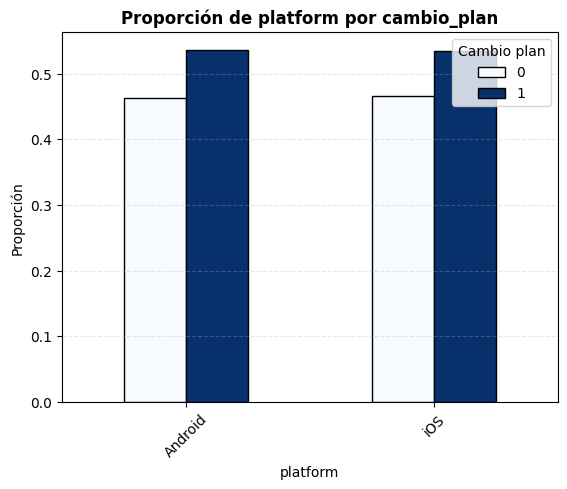

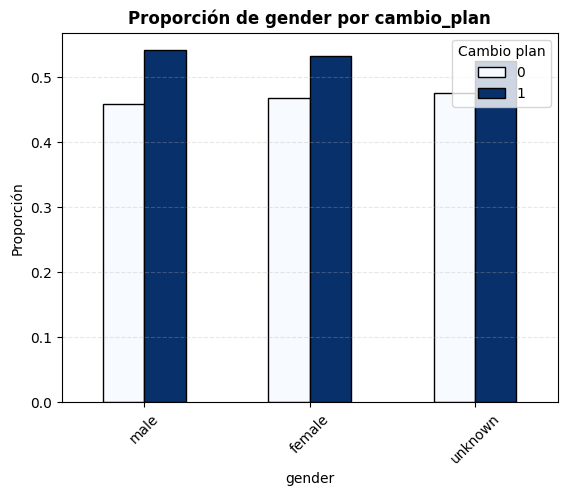

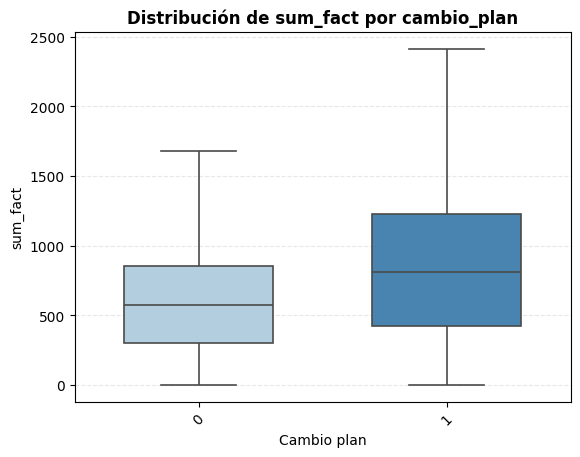

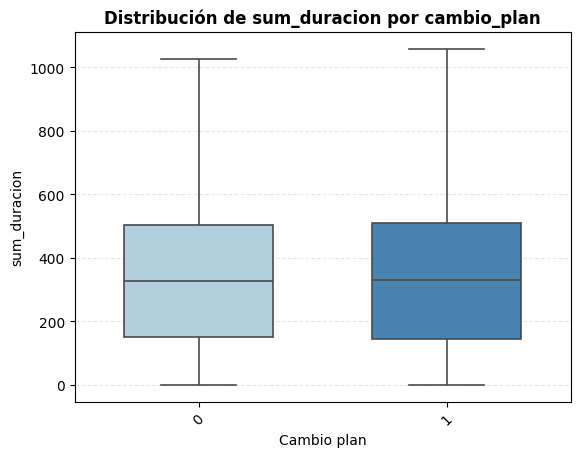

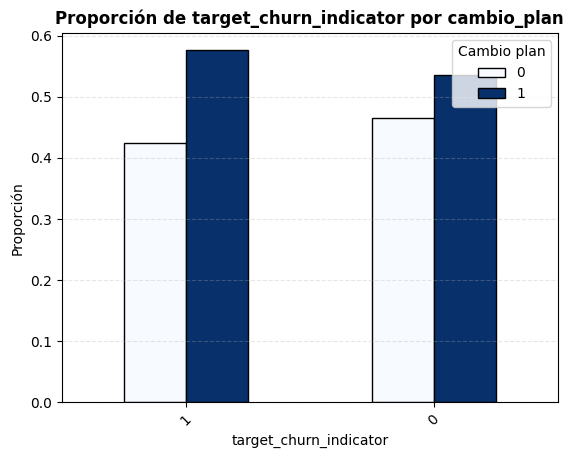

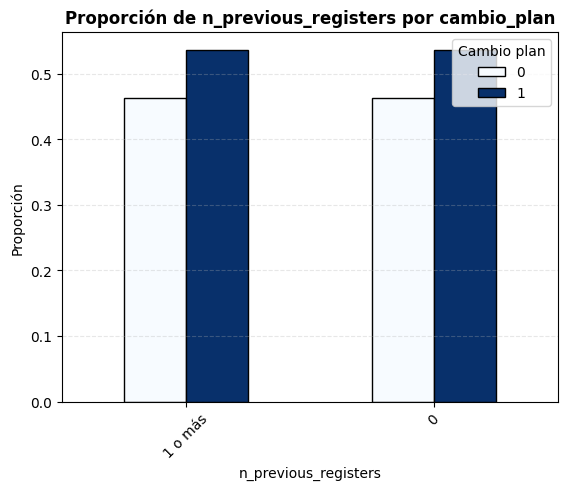

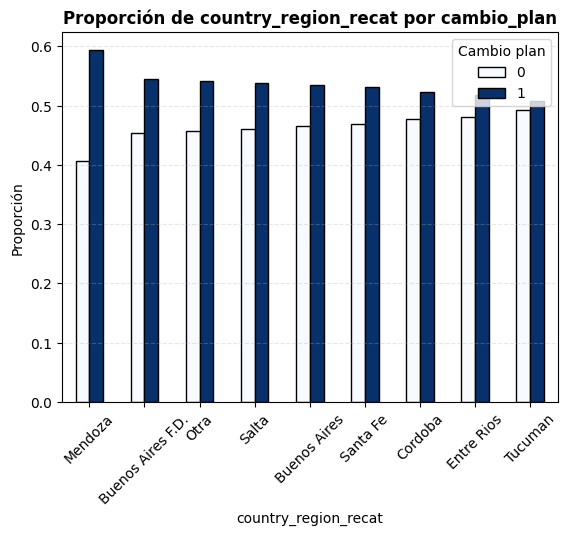

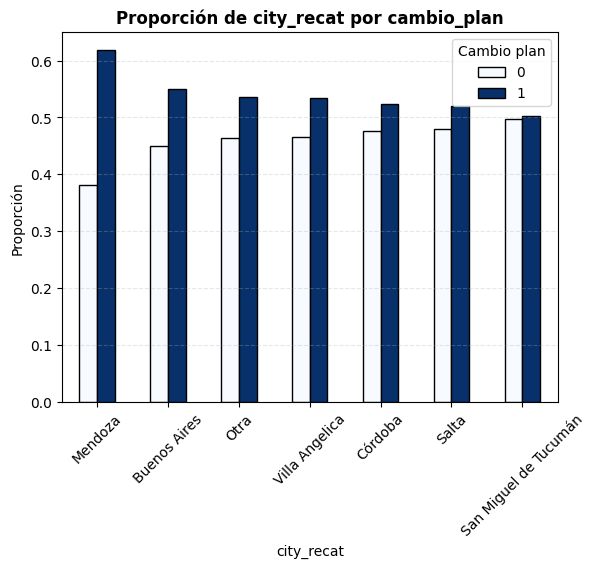

In [58]:
# Pieza de código para extraer gráficos descriptivos sobre la relación entre la variable cambio_plan y el resto
for col in df_q3.columns:

    if col != "cambio_plan":

        if col in cat_int_cols:
            prop_df = df_q3.groupby([col, "cambio_plan"]).size().unstack()
            prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
            sorted_index = prop_df[1].sort_values(ascending=False).index
            prop_df = prop_df.loc[sorted_index]
            prop_df.plot(kind="bar", stacked=False, colormap="Blues", edgecolor="black")
            
            plt.xlabel(col, fontsize=10)
            plt.ylabel("Proporción", fontsize=10)
            plt.title(f"Proporción de {col} por cambio_plan", fontsize=12, fontweight="bold")
            plt.legend(title="Cambio plan", loc="upper right", fontsize=10, title_fontsize=10)
            
        else:
            sns.boxplot(x=df_q3["cambio_plan"], y=df_q3[col], palette="Blues", width=0.6, linewidth=1.2, showfliers=False)
            
            plt.xlabel("Cambio plan", fontsize=10)
            plt.ylabel(col, fontsize=10)
            plt.title(f"Distribución de {col} por cambio_plan", fontsize=12, fontweight="bold")

        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis="y", linestyle="--", alpha=0.3)
        plt.show()

#### **Conclusión a partir de las gráficas**

Las gráficas permiten concluir que la característica más importante que diferencia los clientes que cambiaron de plan vs. los que no lo hicieron es el total de facturación en $ durante todo el trimestre; es probable que dada la cantidad facturada, quisieran cambiar a un plan más económico.

Por otro lado, los clientes de la ciudad y región de Mendoza son los que más cambios de planes han tenido; particularmente en la ciudad, más del 60% ha cambiado su plan en el último trimestre, mientras que en la región esta proporción llega casi al 60%.

Finalmente, cabe resaltar que la proporción de clientes que cambia de plan y que además está en campañas de *churn* es un poco mayor a la proporción de clientes que no está en tales campañas (valor cercano a 0.6), hecho que podría estar relacionado con una efectividad en estos mecanismos, ya que es posible que estos clientes hayan intentado cancelar algún servicio pero con la campaña dirigida hayan decidido tomar algún otro.

### Pregunta 3: ¿cuáles serían las tres principales características de los clientes que realizan cambios de plan? 
#### Ahora usando una regresión logística

In [59]:
# Evidencia de que no existe un desbalance marcado en la variable independiente
df_q3["cambio_plan"].value_counts(normalize=True)

cambio_plan
1    0.536422
0    0.463578
Name: proportion, dtype: float64

In [60]:
# Definición de mis predictores y variable de respuesta
X = df_q3.drop(columns=["cambio_plan"])
y = df_q3["cambio_plan"]

In [61]:
# Conversión de las variables categóricas a variables dummy
X = pd.get_dummies(X, drop_first=True)

In [62]:
# División de la data en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [63]:
# Establecimiento del estandarizados para las vairables numéricas
scaler = StandardScaler()
X_train[X_train.select_dtypes(include=['float64']).columns] = scaler.fit_transform(X_train.select_dtypes(include=['float64']))
X_test[X_test.select_dtypes(include=['float64']).columns] = scaler.transform(X_test.select_dtypes(include=['float64']))

In [64]:
# Vista del dataframe de entrenamiento
X_train.head(3)

,sum_fact,sum_duracion,target_churn_indicator,platform_iOS,gender_male,gender_unknown,n_previous_registers_1 o más,country_region_recat_Buenos Aires F.D.,country_region_recat_Cordoba,country_region_recat_Entre Rios,...,country_region_recat_Otra,country_region_recat_Salta,country_region_recat_Santa Fe,country_region_recat_Tucuman,city_recat_Córdoba,city_recat_Mendoza,city_recat_Otra,city_recat_Salta,city_recat_San Miguel de Tucumán,city_recat_Villa Angelica
nro_cliente,,,,,,,,,,,,,,,,,,,,,
4863,-0.128051,-0.341513,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
10401,0.219772,0.079211,0,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False
2507,-0.972194,0.567343,0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [65]:
# Generación y ajuste del modelo de regresión logística, añadiendo una penalización L1 (Lasso)
model = LogisticRegression(penalty="l1", max_iter=1000, solver="liblinear")
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [66]:
# Muestra de los coeficientes del modelo
model.coef_

array([[ 0.81005829, -0.31935995,  0.14951579, -0.04646017,  0.03257078,
         0.0104537 , -0.01009794, -0.02422041, -0.04372396, -0.02089325,
         0.30234197,  0.06278763,  0.1456904 , -0.01226637, -0.18608084,
        -0.17418619,  0.        , -0.10138562, -0.34799655,  0.        ,
         0.02310663]])

In [67]:
# Se añaden los coeficientes resultantes del modelo a un dataframe
# Se calculan los odds ratio, que permiten mayor interpretabilidad
coefficients = pd.DataFrame({"feature": X.columns, "coefficient": model.coef_[0]})
coefficients["odds_ratio"] = np.exp(coefficients["coefficient"])
coefficients = coefficients.sort_values(by="odds_ratio", ascending=False)

In [68]:
# Muestra de los coeficientes resultantes, organizados según su importancia
coefficients

,feature,coefficient,odds_ratio
0,sum_fact,0.810058,2.248039
10,country_region_recat_Mendoza,0.302342,1.353024
2,target_churn_indicator,0.149516,1.161272
12,country_region_recat_Salta,0.145690,1.156838
11,country_region_recat_Otra,0.062788,1.064801
4,gender_male,0.032571,1.033107
20,city_recat_Villa Angelica,0.023107,1.023376
5,gender_unknown,0.010454,1.010509
16,city_recat_Mendoza,0.000000,1.000000
19,city_recat_San Miguel de Tucumán,0.000000,1.000000


In [69]:
# Predicciones de las etiquetas y probabilidades de la variable de respuesta según el modelo entrenado
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [72]:
# Muestra de la precisión, recall, AUC y reporte general de métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nReporte general:\n", classification_report(y_test, y_pred))

Accuracy: 0.5912844036697248
Recall: 0.6526946107784432
AUC: 0.6482507642620651

Reporte general:
               precision    recall  f1-score   support

           0       0.56      0.52      0.54      1011
           1       0.61      0.65      0.63      1169

    accuracy                           0.59      2180
   macro avg       0.59      0.59      0.59      2180
weighted avg       0.59      0.59      0.59      2180



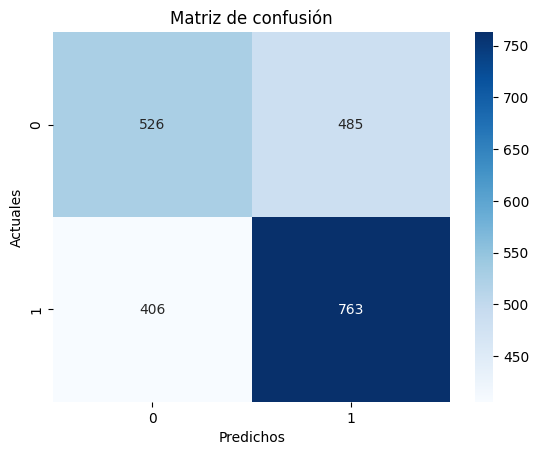

In [71]:
# Matriz de confusión resultante
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predichos")
plt.ylabel("Actuales")
plt.title("Matriz de confusión")
plt.show()

#### **Conclusión a partir del modelo de regresión logística**

Al ajustar un modelo de regresión logística con el fin de validar a un mayor nivel estadístico los resultados obtenidos por las gráficas anteriores, los resultados confirman lo previamente mencionado:

1. La suma total facturada en el trimestre tiene un impacto sobre los clientes que realizan al menos un cambio en el plan. Particularmente, por cada peso ($) que aumenta el total facturado para un cliente, hay un aumento de 2.25 veces en los *odds* de cambiar de plan (lo que se relaciona con una probabilidad mayor de cambiar de plan).

2. Las personas que pertenecen a la región de Mendoza también tienen una mayor probabilidad de cambiar de plan en comparación a personas que residen en otras regiones (*odds ratio* de 1.35).

3. De la misma manera, si un cliente está dentro de las campañas de *churn*, sus odds de cambiar de plan son 1.16 veces mayores en comparación a quienes no hacen parte de estas campañas.

Adicionalmente, vale la pena mencionar que este modelo tiene un área bajo la curva (AUC) de 0.65, que si bien no es un mal resultado, podría ser mejor si se estudiara la posibilidad de agregar más datos o de probar utilizando otro modelo de clasificación, por ejemplo.

Por otro lado, si bien el accuracy no es muy alto (0.59), el recall es de 0.65, que también tiene oportunidades de mejora pero que evidencia que el modelo es aceptable para identificar a los clientes que realmente van a cambiar de plan.